In [ ]:
import pathlib
import numpy as np

labels = {
    'csvgd': 'CSVTO (Ours)',
    'ipopt': 'IPOPT',
    'mppi_100': 'MPPI $\lambda$ = 100',
    'mppi_1000': 'MPPI $\lambda$ = 1000',
    'svgd_100': 'SVMPC $\lambda$ = 100',
    'svgd_1000': 'SVMPC $\lambda$ = 1000',
    'svgd_grad_100': 'SVMPC-grad $\lambda$ = 100',
    'svgd_grad_1000': 'SVMPC-grad $\lambda$ = 1000'
}
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rc('axes', labelsize=14) 

ccai_path = pathlib.Path().resolve().parents[0]

def get_quadrotor_results(experiments_fpath):
    controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
    num_trials = 20

    min_distance_to_goals = {}
    for controller in controllers:
        min_distance_to_goals[str(controller)] = []

    average_constraint_violation = {}
    for controller in controllers:
        average_constraint_violation[str(controller)] = []

    worst_constraint_violation = {}
    for controller in controllers:
        worst_constraint_violation[str(controller)] = []

    #controller_list = ['csvgd', 'ipopt', 'mppi_100', 'mppi_1000', 'svgd_100', 'svgd_1000', 'svgd_grad_100', 'svgd']
    controllers.sort()
    for controller in controllers:
        for i in range(1, num_trials + 1):
            fpath = f'{experiments_fpath}/{controller}/trial_{i}/trajectory.npz'
            data = np.load(fpath)
            x = data['x']
            violation = np.abs(data['constr'][:, 0])

            # distance to goal
            min_d = np.min(np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))
            #min_d = np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))
            min_distance_to_goals[str(controller)].append(min_d)
            average_constraint_violation[str(controller)].append(violation)
            worst_constraint_violation[str(controller)].append(np.max(np.abs(violation)))
        average_constraint_violation[str(controller)] = np.mean(np.stack(average_constraint_violation[str(controller)], axis=0), axis=0)

    return min_distance_to_goals, average_constraint_violation, worst_constraint_violation, controllers

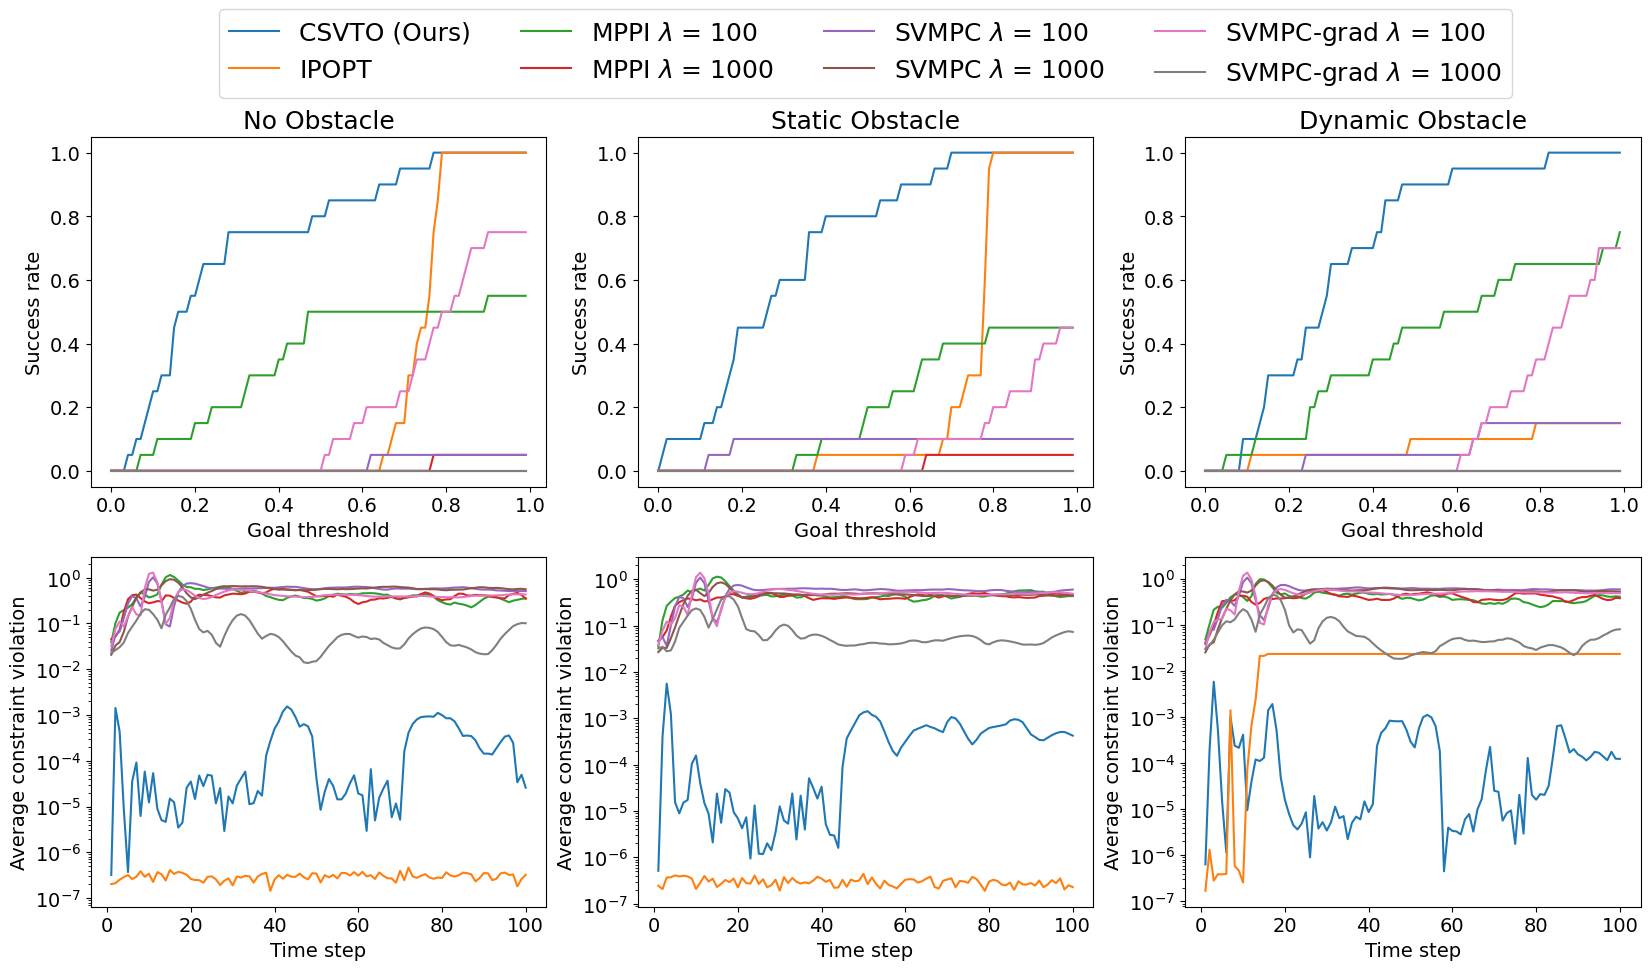

In [66]:
experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/quadrotor_dynamic_temp_05_N8_wide_start2_heuristic2_penalty_100')
min_d_dynamic, av_v_dynamic, _, controllers = get_quadrotor_results(experiments_fpath)
experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/quadrotor_static_temp_05_N8_wide_start2_heuristic2_penalty_100')
min_d_static, av_v_static, _, _ = get_quadrotor_results(experiments_fpath)
experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/quadrotor_noobs_temp_05_N8_wide_start2_heuristic2_penalty_100')
min_d_none, av_v_none, _, _ = get_quadrotor_results(experiments_fpath)

min_d = {
    'none': min_d_none,
    'static': min_d_static,
    'dynamic': min_d_dynamic,
}
av_v = {
    'none': av_v_none,
    'static': av_v_static,
    'dynamic': av_v_dynamic,
}
goal_thresholds = np.arange(0, 1, 0.01)

success_rates = {}
for exp_type in min_d.keys():
    success_rates[exp_type] = {}
    for controller in controllers:
        success_rates[exp_type][str(controller)] = np.zeros(len(goal_thresholds))
        min_d[exp_type][str(controller)] = np.array(min_d[exp_type][str(controller)])
        av_v[exp_type][str(controller)] = np.array(av_v[exp_type][str(controller)])
        for i, threshold in enumerate(goal_thresholds):
            s = np.where(min_d[exp_type][str(controller)] < threshold, 1, 0).sum() / len(min_d[exp_type][str(controller)])
            success_rates[exp_type][str(controller)][i] = s

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

label_exp_type = {
    'dynamic': 'Dynamic Obstacle',
    'static': 'Static Obstacle',
    'none': 'No Obstacle'
}
for i, exp_type in enumerate(min_d.keys()):
    for j, controller in enumerate(controllers):
        axes[0, i].plot(
            goal_thresholds,
            success_rates[exp_type][str(controller)],
            label=fr'{labels[str(controller)]}'
        )
        axes[0, i].set_title(label_exp_type[exp_type], fontsize=18)
        axes[0, i].set_xlabel('Goal threshold')
        axes[0, i].set_ylabel('Success rate')
        axes[1, i].plot(
            np.arange(1, 101),
            av_v[exp_type][str(controller)],
            label=fr'{labels[str(controller)]}'
        )
        axes[1, i].set_xlabel('Time step')
        axes[1, i].set_ylabel('Average constraint violation')
        axes[1, i].set_yscale('log')

axes[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.4),
ncol=4, fancybox=True, shadow=False, fontsize=18)
plt.show()


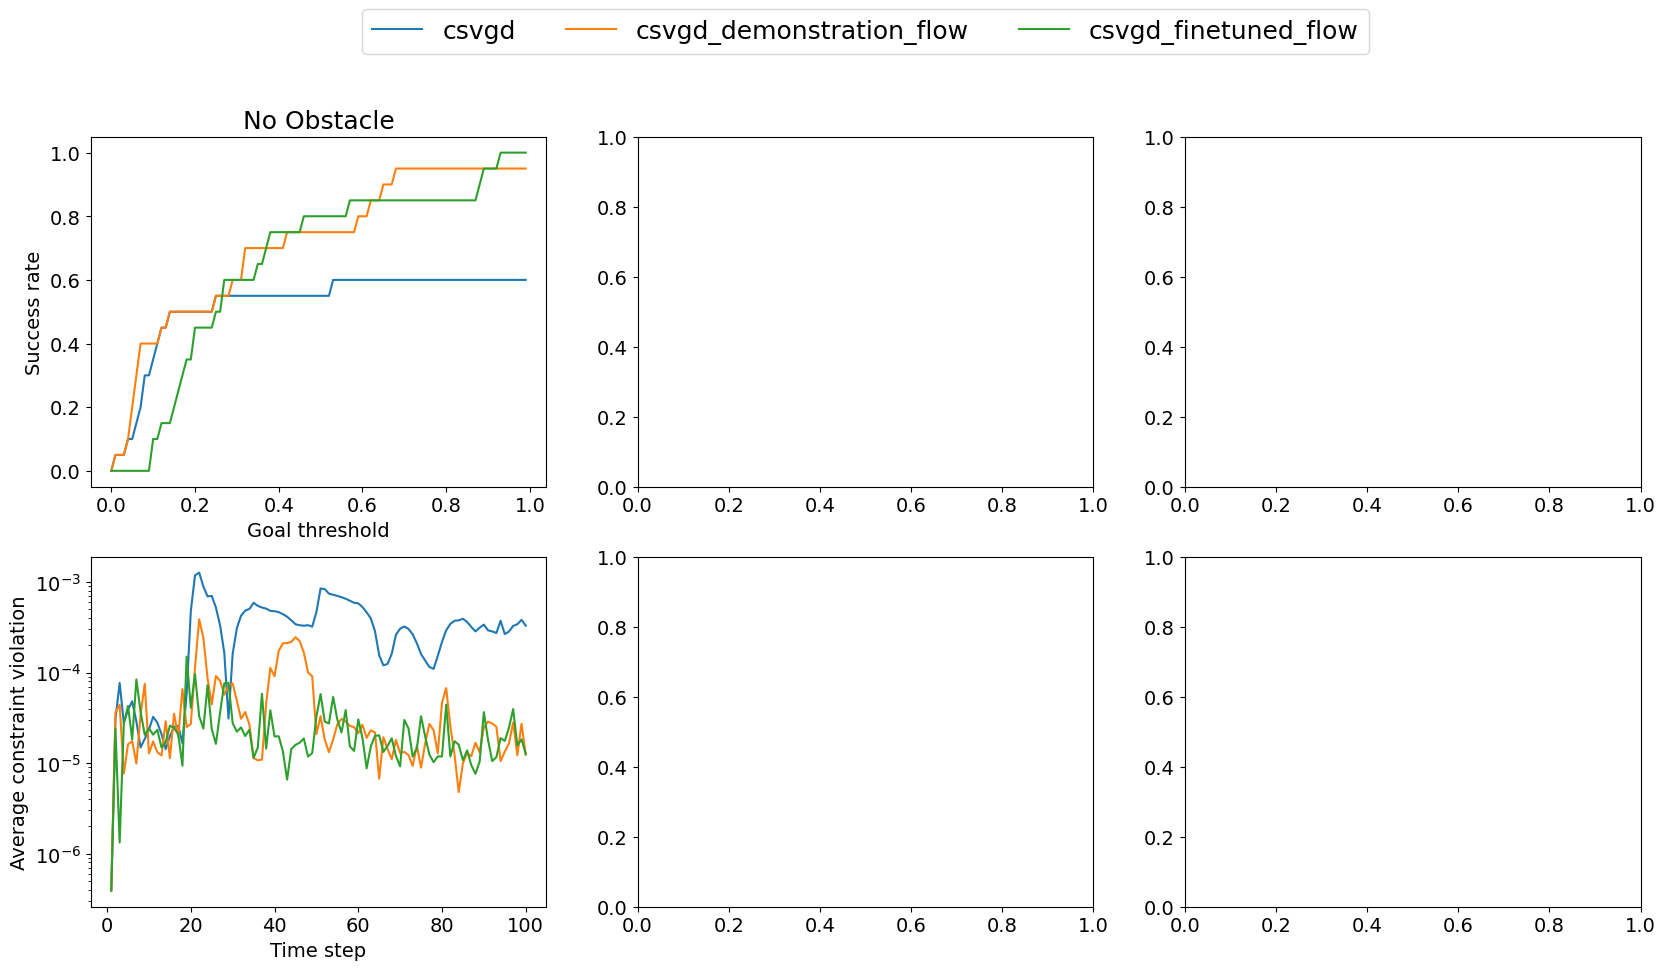

In [67]:
experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/quadrotor_flow_test_multi_constraints')
min_d_none, av_v_none, _, controllers = get_quadrotor_results(experiments_fpath)


min_d = {
    'none': min_d_none,
}
av_v = {
    'none': av_v_none,
}
goal_thresholds = np.arange(0, 1, 0.01)

success_rates = {}
for exp_type in min_d.keys():
    success_rates[exp_type] = {}
    for controller in controllers:
        success_rates[exp_type][str(controller)] = np.zeros(len(goal_thresholds))
        min_d[exp_type][str(controller)] = np.array(min_d[exp_type][str(controller)])
        av_v[exp_type][str(controller)] = np.array(av_v[exp_type][str(controller)])
        for i, threshold in enumerate(goal_thresholds):
            s = np.where(min_d[exp_type][str(controller)] < threshold, 1, 0).sum() / len(min_d[exp_type][str(controller)])
            success_rates[exp_type][str(controller)][i] = s

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

label_exp_type = {
    'dynamic': 'Dynamic Obstacle',
    'static': 'Static Obstacle',
    'none': 'No Obstacle'
}
for i, exp_type in enumerate(min_d.keys()):
    for j, controller in enumerate(controllers):
        axes[0, i].plot(
            goal_thresholds,
            success_rates[exp_type][str(controller)],
            label=str(controller)
        )
        axes[0, i].set_title(label_exp_type[exp_type], fontsize=18)
        axes[0, i].set_xlabel('Goal threshold')
        axes[0, i].set_ylabel('Success rate')
        axes[1, i].plot(
            np.arange(1, 101),
            av_v[exp_type][str(controller)],
            label=str(controller)
        )
        axes[1, i].set_xlabel('Time step')
        axes[1, i].set_ylabel('Average constraint violation')
        axes[1, i].set_yscale('log')

axes[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.4),
ncol=4, fancybox=True, shadow=False, fontsize=18)
plt.show()


In [58]:
### victor table figs
import pathlib
import numpy as np

ccai_path = pathlib.Path().resolve().parents[0]

experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/victor_table_jointspace')

controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
controllers.sort()
num_trials = 20

min_distance_to_goals = {}
applied_force = {}
for controller in controllers:
    min_distance_to_goals[str(controller)] = []

average_constraint_violation = {}
worst_constraint_violation = {}

for controller in controllers:
    average_constraint_violation[str(controller)] = []

for controller in controllers:
    worst_constraint_violation[str(controller)] = []

for controller in controllers:
    applied_force[str(controller)] = []

for controller in controllers:
    for i in range(1, num_trials + 1):
        fpath = f'{experiments_fpath}/{controller}/trial_{i}/trajectory.npz'
        data = np.load(fpath)
        x = data['x']
        violation = np.abs(data['constr']).reshape(-1, 2)

        # z violation
        violation[:, 0] = np.clip(violation[:, 0] - 3e-3, a_max=None, a_min=0)

        # distance to goal
        #min_d = np.min(np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))

        min_d = np.min(data['d2goal'])
        min_distance_to_goals[str(controller)].append(min_d)
        average_constraint_violation[str(controller)].append(violation)

        worst_constraint_violation[str(controller)].append(np.max(np.abs(violation)))

    average_constraint_violation[str(controller)] = np.mean(np.stack(average_constraint_violation[str(controller)], axis=0), axis=0)

KeyError: 'constr is not a file in the archive'

In [356]:
goal_thresholds = np.arange(0, 0.101, 0.01)
print(goal_thresholds)
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(goal_thresholds)

for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    max_v = np.array(worst_constraint_violation[str(controller)])
    for i, threshold in enumerate(goal_thresholds):
        s = np.where(np.logical_and(min_d < threshold, max_v < 0.01) , 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s



import matplotlib.pyplot as plt

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


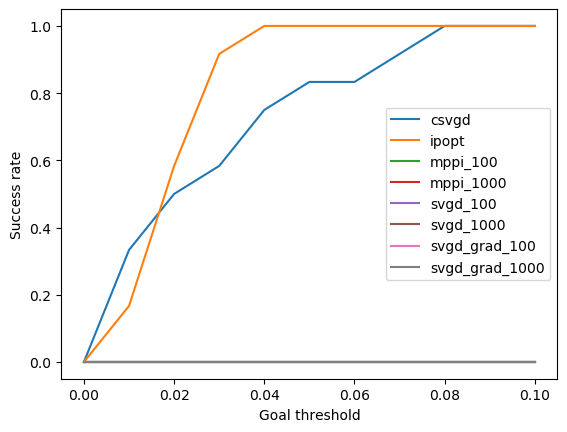

In [357]:
import matplotlib.pyplot as plt
for controller in controllers:

    plt.plot(
        goal_thresholds,
        success_rates[str(controller)],
        label=str(controller)
    )
plt.xlabel('Goal threshold')
plt.ylabel('Success rate')
plt.legend()
plt.show()

(26, 2)
(26, 2)
(26, 2)
(26, 2)
(26, 2)
(26, 2)
(26, 2)
(26, 2)


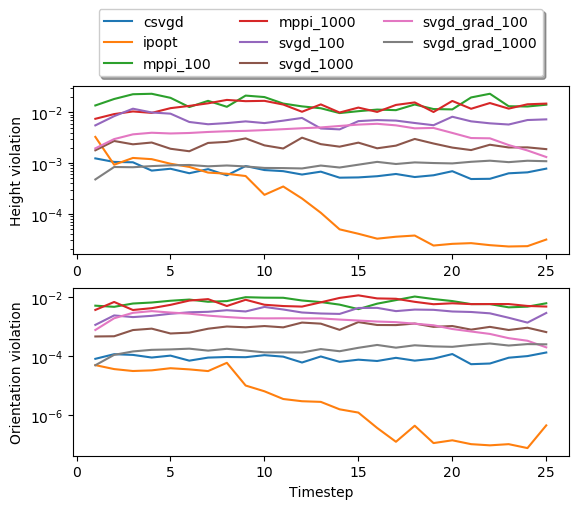

In [348]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1)
for controller in controllers:

    print(average_constraint_violation[str(controller)].shape)
    
    
    axes[0].plot(
        np.arange(1, 26),
        average_constraint_violation[str(controller)][1:, 0],
        label=str(controller)
    )
    axes[1].plot(
        np.arange(1, 26),
        average_constraint_violation[str(controller)][1:, 1],
        label=str(controller)
    )
    #axes[1].set_ylim([-0.005, 0.005])
#
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.xlabel('Timestep')
axes[0].set_ylabel('Height violation')
axes[1].set_ylabel('Orientation violation')

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=3, fancybox=True, shadow=True)
plt.show()


csvgd
[0.   0.   0.7  0.95 1.   1.   1.   1.   1.   1.  ]
ipopt
[0.   0.   0.1  0.4  0.6  0.75 0.8  0.9  0.95 0.95]
mppi_100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mppi_1000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
svgd_100
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.05]
svgd_1000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
svgd_grad_100
[0.   0.   0.   0.   0.   0.   0.   0.1  0.35 0.4 ]
svgd_grad_1000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


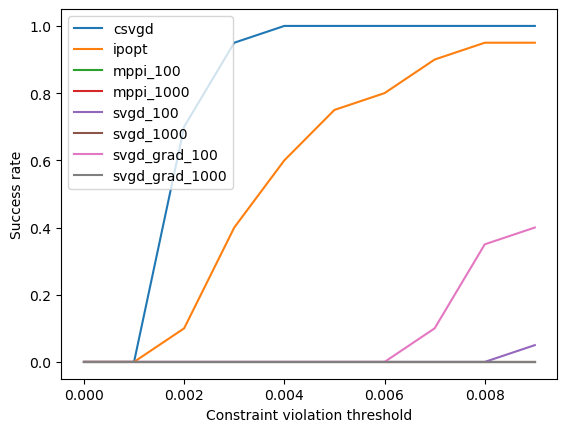

In [344]:
thresholds = np.arange(0.0, 0.01, 0.001)
controllers.sort()
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(thresholds)

for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    max_v = np.array(worst_constraint_violation[str(controller)])
    for i, threshold in enumerate(thresholds):
        s = np.where(np.logical_and(min_d < 0.1, max_v < threshold), 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s

import matplotlib.pyplot as plt
for controller in controllers:

    print(controller)
    print(success_rates[str(controller)])
    plt.plot(
        thresholds,
        success_rates[str(controller)],
        label=str(controller)
    )
plt.xlabel('Constraint violation threshold')
plt.ylabel('Success rate')
plt.legend()
plt.show()

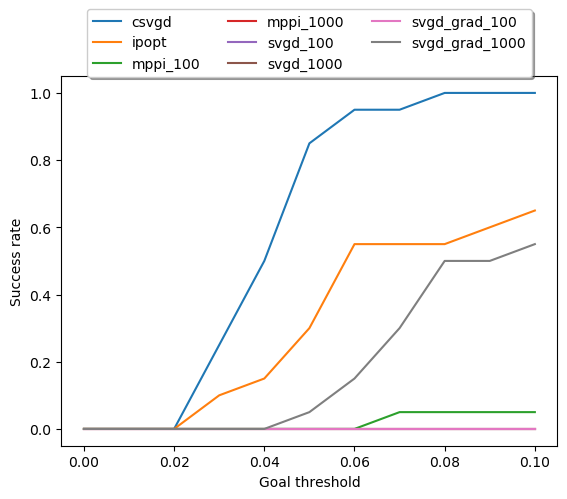

In [331]:
### victor table figs
import pathlib
import numpy as np

ccai_path = pathlib.Path().resolve().parents[0]

experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/victor_wrench')

controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
controllers.sort()
num_trials = 20

min_distance_to_goals = {}
applied_force = {}
for controller in controllers:
    min_distance_to_goals[str(controller)] = []

average_constraint_violation = {}
worst_constraint_violation = {}

for controller in controllers:
    average_constraint_violation[str(controller)] = []

for controller in controllers:
    worst_constraint_violation[str(controller)] = []

for controller in controllers:
    applied_force[str(controller)] = []

for controller in controllers:
    for i in range(1, num_trials + 1):
        fpath = f'{experiments_fpath}/{controller}/trial_{i}/trajectory.npz'
        data = np.load(fpath)
        x = data['x']

        min_d = np.min(np.abs((x[-1, -1] + np.pi / 2.0)))
        min_distance_to_goals[str(controller)].append(min_d)

goal_thresholds = np.arange(0, 0.11, 0.01)
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(goal_thresholds)

for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    for i, threshold in enumerate(goal_thresholds):
        s = np.where(min_d < threshold , 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s


import matplotlib.pyplot as plt
for controller in controllers:

    plt.plot(
        goal_thresholds,
        success_rates[str(controller)],
        label=str(controller)
    )
plt.xlabel('Goal threshold')
plt.ylabel('Success rate')

plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)
plt.show()

{'csvgd': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'csvgd_obstacle_diffusion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'csvgd_table_and_obstacle_diffusion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'csvgd_table_diffusion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


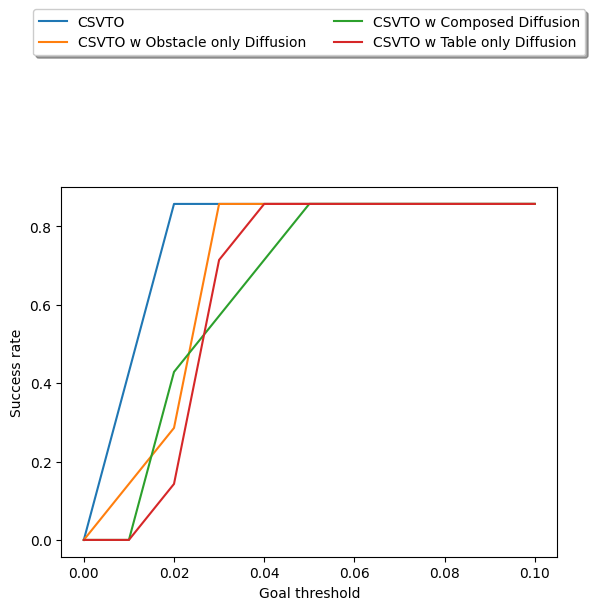

(26, 2)
(26, 2)
(26, 2)
(26, 2)


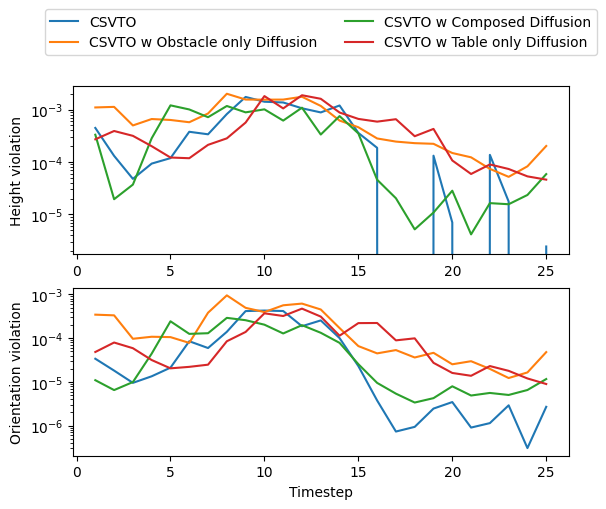

{'csvgd': 27.099015938907, 'csvgd_obstacle_diffusion': 27.73510724611272, 'csvgd_table_and_obstacle_diffusion': 25.03085009658561, 'csvgd_table_diffusion': 32.65070954587593}


In [5]:
### victor table figs
import pathlib
import numpy as np

ccai_path = pathlib.Path().resolve().parents[0]

experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/victor_table_jointspace_sphere_obs_1_v2')

controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
controllers.sort()
num_trials = 7
#controllers = controllers[:-1]
min_distance_to_goals = {}
applied_force = {}
cost = {}
for controller in controllers:
    min_distance_to_goals[str(controller)] = []

average_constraint_violation = {}
worst_constraint_violation = {}
max_obs_violation = {}


for controller in controllers:
    average_constraint_violation[str(controller)] = []
    max_obs_violation[str(controller)] = []
for controller in controllers:
    worst_constraint_violation[str(controller)] = []

for controller in controllers:
    applied_force[str(controller)] = []

for controller in controllers:
    cost[str(controller)] = 0.0

for controller in controllers:
    for i in range(1, num_trials + 1):
        fpath = f'{experiments_fpath}/{controller}/trial_{i}/trajectory.npz'
        data = np.load(fpath)
        x = data['x']
        violation = np.abs(data['constr']).reshape(-1, 2)
        #obs_violation = np.clip(data['obs_constr']-0.05, a_min=0, a_max=None)
        obs_violation = np.array([0.0])
        max_obs_violation[str(controller)].append(np.max(obs_violation))
        
        # z violation
        violation[:, 0] = np.clip(violation[:, 0] - 2.2e-3, a_max=None, a_min=0)

        # distance to goal
        #min_d = np.min(np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))

        min_d = np.min(data['d2goal'])
        min_distance_to_goals[str(controller)].append(min_d)
        average_constraint_violation[str(controller)].append(violation)
        
        worst_constraint_violation[str(controller)].append(np.max(np.abs(violation)))
        weight = 1.0 / np.array([0.2, 0.25, 0.4, 0.4, 0.6, 0.75, 1.0])
        diff = np.diff(x, axis=0)
        path_cost = np.einsum('bi,i,bi->b', diff, weight, diff)

        cost[str(controller)] += np.sum(path_cost)
        cost[str(controller)] += np.sum(data['d2goal']**2)
        

    average_constraint_violation[str(controller)] = np.mean(np.stack(average_constraint_violation[str(controller)], axis=0), axis=0)


print(max_obs_violation)
goal_thresholds = np.arange(0, 0.101, 0.01)
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(goal_thresholds)

for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    max_v = np.array(worst_constraint_violation[str(controller)])
    max_obs = np.array(max_obs_violation[str(controller)])
    print(max_obs)
    for i, threshold in enumerate(goal_thresholds):
        s = np.where(np.logical_and(min_d < threshold, max_obs==0.0) , 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s

labels = {
    'csvgd': 'CSVTO',
    'csvgd_table_and_obstacle_diffusion': 'CSVTO w Composed Diffusion',
    'csvgd_obstacle_diffusion': 'CSVTO w Obstacle only Diffusion',
    'csvgd_table_diffusion': 'CSVTO w Table only Diffusion',
}
import matplotlib.pyplot as plt
for controller in controllers:

    plt.plot(
        goal_thresholds,
        success_rates[str(controller)],
        label=labels[str(controller)]
    )
plt.xlabel('Goal threshold')
plt.ylabel('Success rate')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=2, fancybox=True, shadow=True)
plt.show()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1)
for controller in controllers:
    print(average_constraint_violation[str(controller)].shape)

    axes[0].plot(
        np.arange(1, 26),
        average_constraint_violation[str(controller)][1:, 0],
        label=labels[str(controller)]
    )
    axes[1].plot(
        np.arange(1, 26),
        average_constraint_violation[str(controller)][1:, 1],
        label=labels[str(controller)]
    )
    #axes[1].set_ylim([-0.005, 0.005])
#
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.xlabel('Timestep')
axes[0].set_ylabel('Height violation')
axes[1].set_ylabel('Orientation violation')

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=2, fancybox=True, shadow=False)
plt.show()

print(cost)

[PosixPath('csvgd'), PosixPath('csvgd_diffusion_flow_obs_only'), PosixPath('csvgd_diffusion_flow_surf_and_obs'), PosixPath('csvgd_diffusion_flow_surf_only')]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


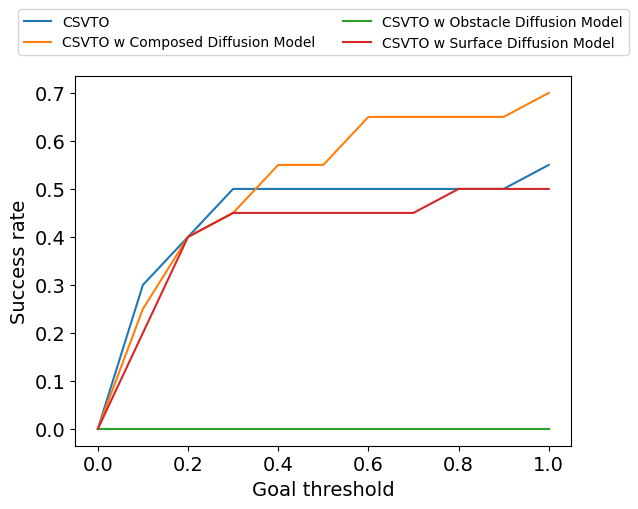

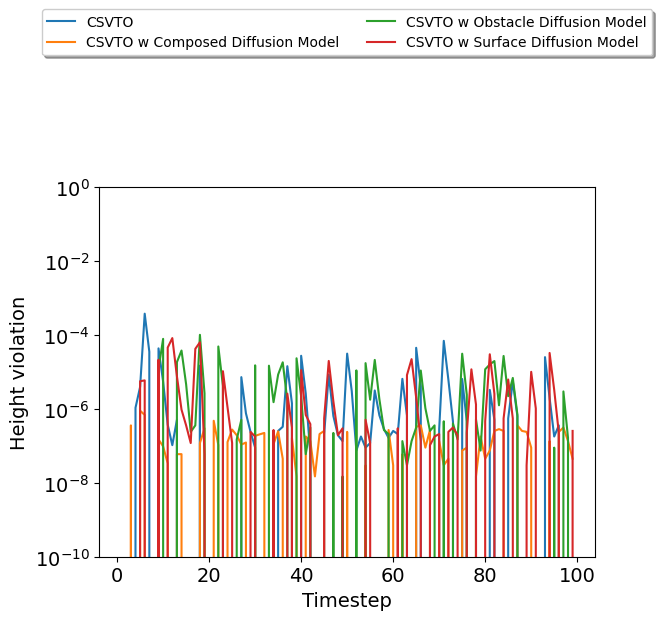

In [8]:
### victor table figs
import pathlib
import numpy as np

ccai_path = pathlib.Path().resolve().parents[0]

experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/test_quadrotor_composable')

controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
controllers.sort()
num_trials = 1

min_distance_to_goals = {}
applied_force = {}
cost = {}
for controller in controllers:
    min_distance_to_goals[str(controller)] = []

print(controllers)
controllers = [controllers[0], controllers[2], controllers[1], controllers[3]]
average_constraint_violation = {}
worst_constraint_violation = {}

for controller in controllers:
    average_constraint_violation[str(controller)] = []

for controller in controllers:
    worst_constraint_violation[str(controller)] = []

for controller in controllers:
    applied_force[str(controller)] = []

for controller in controllers:
    cost[str(controller)] = 0.0

for controller in controllers:
    for i in range(1, num_trials + 1):
        fpath = f'{experiments_fpath}/{controller}/trial_{i}/planned_trajector_data.npz'
        data = np.load(fpath, allow_pickle=True)
        x = data['traj']
        violation = np.array(data['violation'][()]['surface'])
        
        # distance to goal
        #min_d = np.min(np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))

        min_d = np.min(np.linalg.norm(x[:, 0, 0, :2] - data['goal'][:2]))
        min_distance_to_goals[str(controller)].append(min_d)
        average_constraint_violation[str(controller)].append(violation)

        worst_constraint_violation[str(controller)].append(np.max(np.abs(violation)))
        cost[str(controller)] += np.sum(np.diff(x, axis=1)**2)


    average_constraint_violation[str(controller)] = np.mean(np.stack(average_constraint_violation[str(controller)], axis=0), axis=0)



# from terminal since didn't save proooooperly
min_distance_to_goals = {'csvgd': [0.0013421434045243737, 1.6161634630745163, 0.9273501348816777, 0.15378784295775147, 4.7083174096617695, 0.28731276860184074, 3.161045794643137, 0.0011425458596055192, 0.15864416397860467, 0.07123807259733414, 1.3248716977456163, 0.025404533634782817, 3.374748971461314, 3.5287817495871034, 2.147551442782179, 0.028385488168136706, 1.4404053320792372, 0.05718909908057027, 0.24213446904648495, 1.2742694285471319], 'csvgd_diffusion_flow_surf_only': [0.014066867282722864, 2.2331174564552447, 0.768551583415833, 0.12373833418767566, 4.602038430906272, 0.18592164740866565, 3.507773481184843, 6.216314051509715, 0.15328166279750757, 0.05294179497852409, 1.0672272900816824, 0.028396584455895008, 3.361394154359321, 3.4001968612184528, 6.234880555088395, 0.04866854265383382, 1.4550625922750742, 0.15350924131781757, 0.21125989228469155, 1.2018832528022336], 'csvgd_diffusion_flow_obs_only': [0.013518367322120806, 7.0209574551869025, 1.0766931999474862, 0.12666145570722354, 4.0929369717144475, 0.10119663056493318, 3.2204559587604713, 0.017233170222172176, 0.19314584143228233, 0.11148363994985495, 1.2485892822273315, 0.12696476880728605, 3.3080087518063754, 3.5227290634650843, 2.164378978145032, 3.994121512950429, 1.4585211632649666, 0.25824358237709716, 0.2066647307354675, 7.403474506732269], 'csvgd_diffusion_flow_surf_and_obs': [0.010055983716033468, 1.6115329805457796, 0.3806561880682978, 0.1026251541923802, 5.578743685945159, 0.5942727090082289, 3.131697634984972, 0.009697817708029048, 0.0923467530077083, 0.22325583644472166, 0.9021975730637006, 0.09390203107274889, 3.407202361007166, 3.3889376916423686, 1.2100527220608122, 0.03782120574215671, 0.5208877793489279, 0.3347298226308066, 0.13816600150368055, 0.10489451617740776]}

goal_thresholds = np.arange(0, 1.01, 0.1)
print(goal_thresholds)
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(goal_thresholds)

    
for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    max_v = np.array(worst_constraint_violation[str(controller)])
    for i, threshold in enumerate(goal_thresholds):
        s = np.where(np.logical_and(min_d < threshold, max_v < 0.01) , 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s

labels = {
    'csvgd': 'CSVTO',
    'csvgd_diffusion_flow_surf_and_obs': 'CSVTO w Composed Diffusion Model',
    'csvgd_diffusion_flow_obs_only': 'CSVTO w Obstacle Diffusion Model',
    'csvgd_diffusion_flow_surf_only': 'CSVTO w Surface Diffusion Model',

}
import matplotlib.pyplot as plt
for controller in controllers:

    plt.plot(
        goal_thresholds,
        success_rates[str(controller)],
        label=labels[str(controller)]
    )
print(goal_thresholds)
plt.xlabel('Goal threshold')
plt.ylabel('Success rate')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=False)
plt.show()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)
for controller in controllers:
    axes.plot(
        np.arange(1, 100),
        average_constraint_violation[str(controller)][1:],
        label=labels[str(controller)]
    )
    #axes[1].set_ylim([-0.005, 0.005])
#
axes.set_ylim([1e-10, 1])
axes.set_yscale('log')

plt.xlabel('Timestep')
axes.set_ylabel('Height violation')

axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=2, fancybox=True, shadow=True)
plt.show()

In [2]:
### victor table figs
import pathlib
import numpy as np

ccai_path = pathlib.Path().resolve().parents[0]

experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/test_quadrotor_composable_3')

controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
controllers.sort()
num_trials = 2

min_distance_to_goals = {}
applied_force = {}
cost = {}
for controller in controllers:
    min_distance_to_goals[str(controller)] = []

print(controllers)
#controllers = [controllers[0], controllers[2], controllers[1], controllers[3]]
average_constraint_violation = {}
worst_constraint_violation = {}

for controller in controllers:
    average_constraint_violation[str(controller)] = []

for controller in controllers:
    worst_constraint_violation[str(controller)] = []

for controller in controllers:
    applied_force[str(controller)] = []

for controller in controllers:
    cost[str(controller)] = 0.0

for controller in controllers:
    for i in range(1, num_trials + 1):
        fpath = f'{experiments_fpath}/{controller}/trial_{i}/planned_trajectory_data.npz'
        data = np.load(fpath, allow_pickle=True)
        x = data['traj']
        violation = np.array(data['violation'][()]['surface'])
        
        # distance to goal
        #min_d = np.min(np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))
        print(x.shape)
        min_d = np.min(np.linalg.norm(x[:, :, 0, :2] - data['goal'][:2], axis=1))
        min_distance_to_goals[str(controller)].append(min_d)
        average_constraint_violation[str(controller)].append(np.abs(violation))

        worst_constraint_violation[str(controller)].append(np.max(np.abs(violation)))
        cost[str(controller)] += np.sum(np.diff(x, axis=1)**2)


    average_constraint_violation[str(controller)] = np.mean(np.stack(average_constraint_violation[str(controller)], axis=0), axis=0)
    print(str(controller), np.mean(average_constraint_violation[str(controller)]), np.mean(min_distance_to_goals[str(controller)]))
    


# from terminal since didn't save proooooperly
#min_distance_to_goals = {'csvgd': [0.0013421434045243737, 1.6161634630745163, 0.9273501348816777, 0.15378784295775147, 4.7083174096617695, 0.28731276860184074, 3.161045794643137, 0.0011425458596055192, 0.15864416397860467, 0.07123807259733414, 1.3248716977456163, 0.025404533634782817, 3.374748971461314, 3.5287817495871034, 2.147551442782179, 0.028385488168136706, 1.4404053320792372, 0.05718909908057027, 0.24213446904648495, 1.2742694285471319], 'csvgd_diffusion_flow_surf_only': [0.014066867282722864, 2.2331174564552447, 0.768551583415833, 0.12373833418767566, 4.602038430906272, 0.18592164740866565, 3.507773481184843, 6.216314051509715, 0.15328166279750757, 0.05294179497852409, 1.0672272900816824, 0.028396584455895008, 3.361394154359321, 3.4001968612184528, 6.234880555088395, 0.04866854265383382, 1.4550625922750742, 0.15350924131781757, 0.21125989228469155, 1.2018832528022336], 'csvgd_diffusion_flow_obs_only': [0.013518367322120806, 7.0209574551869025, 1.0766931999474862, 0.12666145570722354, 4.0929369717144475, 0.10119663056493318, 3.2204559587604713, 0.017233170222172176, 0.19314584143228233, 0.11148363994985495, 1.2485892822273315, 0.12696476880728605, 3.3080087518063754, 3.5227290634650843, 2.164378978145032, 3.994121512950429, 1.4585211632649666, 0.25824358237709716, 0.2066647307354675, 7.403474506732269], 'csvgd_diffusion_flow_surf_and_obs': [0.010055983716033468, 1.6115329805457796, 0.3806561880682978, 0.1026251541923802, 5.578743685945159, 0.5942727090082289, 3.131697634984972, 0.009697817708029048, 0.0923467530077083, 0.22325583644472166, 0.9021975730637006, 0.09390203107274889, 3.407202361007166, 3.3889376916423686, 1.2100527220608122, 0.03782120574215671, 0.5208877793489279, 0.3347298226308066, 0.13816600150368055, 0.10489451617740776]}

goal_thresholds = np.arange(0, 1.01, 0.1)
print(goal_thresholds)
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(goal_thresholds)

    
for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    max_v = np.array(worst_constraint_violation[str(controller)])
    for i, threshold in enumerate(goal_thresholds):
        s = np.where(np.logical_and(min_d < threshold, max_v < 0.01) , 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s

labels = {
    'csvgd': 'CSVTO',
    'csvgd_diffusion_flow_surf_and_obs': 'CSVTO w Composed Diffusion Model',
    'csvgd_constrained_diffusion': 'CSVTO w Constrained Diffusion',
    'csvgd_diffusion_flow_surf_and_obs_no_opt': 'Composed Diffusion Model',
    'csvgd_constrained_diffusion_no_opt': 'Constrained Diffusion'
}
import matplotlib.pyplot as plt
for controller in controllers:

    plt.plot(
        goal_thresholds,
        success_rates[str(controller)],
        label=labels[str(controller)]
    )
plt.xlabel('Goal threshold')
plt.ylabel('Success rate')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=False)
plt.show()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)
for controller in controllers:
    axes.plot(
        np.arange(1, 100),
        average_constraint_violation[str(controller)][1:],
        label=labels[str(controller)]
    )
    #axes[1].set_ylim([-0.005, 0.005])
#
axes.set_ylim([1e-10, 1])
axes.set_yscale('log')

plt.xlabel('Timestep')
axes.set_ylabel('Height violation')

axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=2, fancybox=True, shadow=True)
plt.show()

[PosixPath('csvgd'), PosixPath('csvgd_obstacle_diffusion'), PosixPath('csvgd_table_and_obstacle_diffusion'), PosixPath('csvgd_table_diffusion')]


FileNotFoundError: [Errno 2] No such file or directory: '/home/tpower/dev/research/constrained_cai/data/experiments/victor_table_jointspace_sphere_obs/csvgd/trial_1/planned_trajectory_data.npz'